<a id="top"></a>
# Masking Persistence in WFC3/IR Images
***
## Learning Goals

This notebook shows how to use the Hubble Space Telescope WFC3/IR persistence model to flag pixels affected by persistence in the calibrated (FLT) science images. When the images are sufficiently dithered to step over the observed persistence artifacts, AstroDrizzle may be used to exclude those flagged pixels when combining the FLT frames.  

By the end of this tutorial, you will: 

- Download images and persistence products from MAST.
- Flag affected pixels in the data quality arrays of the FLT images.
- Redrizzle the FLT images to produce a "clean" DRZ combined product.

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#import) <br>
[2. Data](#data) <br>
- [2.1 Download the WFC3/IR observations from MAST](#images) <br>
- [2.2 Download the persistence model products](#model) <br>

[3. Analysis](#analysis) <br>
- [3.1 Display the images](#display) <br>
- [3.2 Use the persistence model to add DQ flags](#flag) <br>
- [3.3 Redrizzle the FLT data and apply the new DQ flags](#drizzle) <br>
- [3.4 Compare the original and corrected DRZ files](#compare) <br>
- [3.5 Compare the original and corrected WHT files](#weight) <br>

[4. Conclusions](#conclusions) <br>
[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>

## Introduction <a id="intro"></a>

Image persistence in the IR array occurs whenever a pixel is exposed to light that exceeds more than about half of the full well of a pixel in the array. Persistence can occur within a single visit, as the different exposures in a visit are dithered. Persistence also occurs from observations in a previous visit of completely different fields.

Image persistence is seen in a small, but non-negligible fraction of WFC3/IR exposures. Its properties are discussed in in [Section 5.7.9](https://hst-docs.stsci.edu/wfc3ihb/chapter-5-wfc3-detector-characteristics-and-performance/5-7-ir-detector-characteristics-and-performance#id-5.7IRDetectorCharacteristicsandPerformance-5.7.95.7.9ImagePersistence) of the WFC3 Instrument Handbook and in [Chapter 8](https://hst-docs.stsci.edu/wfc3dhb/chapter-8-persistence-in-wfc3-ir) of the WFC3 Data Handbook. Persistence is primarily a function of the degree to which a pixel is filled (in electrons) and the time since this occurred. Additional information is available from the [WFC3 Persistence Webpage](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/ir-persistence).

As described in [Section 8.3](https://hst-docs.stsci.edu/wfc3dhb/chapter-8-persistence-in-wfc3-ir/8-3-mitigating-the-effects-of-persistence) of the Data Handbook, there are two possible ways to mitigate persistence: 1.) exclude the affected pixels from the analysis or 2.) subtract the persistence model directly from the image.

This notebook illustrates the first method and shows how to use the model to flag affected pixels in the data quality (DQ) array of each FLT image. When the images are sufficiently dithered, affected regions of the detector may be replaced with 'good' pixels from other exposures in the visit when combining the exposures with AstroDrizzle. Note that this reduces the effective exposure time in those regions of the combined image. 

In the second method, the persistence-corrected FLT frames, downloaded in [Section 2.2](#model) of this notebook, may be used directly for analysis. Alternatively, a scaled version of the persistence model may be subtracted from each FLT image until an adequate correction is achieved. In this case, flagging the affected pixels in the DQ arrays would not be required.

## 1. Imports <a id="import"></a>
    
This notebook assumes you have installed the required libraries as described [here](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/persistence).

We import: 

- *glob* for finding lists of files
- *os* for setting environment variables
- *shutil* for managing directories
- *urllib* for obtaining the Persistence products from MAST

- *matplotlib.pyplot* for plotting data

- *astropy.io fits* for accessing FITS files
- *astroquery* for downloading data from MAST
- *ccdproc* for querying keyword values in the FITS headers

- *drizzlepac astrodrizzle* for combining images

In [1]:
import glob 
import os 
import shutil
import urllib

import matplotlib.pyplot as plt

from astropy.io import fits
from astroquery.mast import Observations
from ccdproc import ImageFileCollection

from drizzlepac import astrodrizzle

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 2. Data <a id="data"></a>

### 2.1 Download the WFC3/IR observations from MAST <a id="images"></a>

Here, we obtain WFC3/IR observations from the Grism Lens-Amplified Survey from Space (GLASS) program 13459, Visit 29 in the F140W filter. These exposures were impacted by persistence from grism G102 exposures obtained just prior to these. 

The following commands query the Mikulski Archive for Space Telescopes (MAST) and then download the FLT and DRZ data products to the current directory.

In [2]:
data_list = Observations.query_criteria(obs_id="ica529*", filters="F140W")

Observations.download_products(
    data_list["obsid"],
    mrp_only=False,
    download_dir="./data",
    productSubGroupDescription=["FLT", "DRZ"],
)

science_files = glob.glob("data/mastDownload/HST/*/*fits")

for im in science_files:
    filename = os.path.basename(im)
    new_path = os.path.join(".", filename)
    os.rename(im, new_path)

data_directory = "./data"

try:
    if os.path.isdir(data_directory):
        shutil.rmtree(data_directory)
except Exception as e:
    print(f"An error occured while deleting the directory {data_directory}: {e}")

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


This Visit contains 4 consecutive dithered FLT exposures in the F140W filter, which are obtained in a single orbit. The following commands print the values of keywords describing those data, where the POSTARG* values represent the commanded x-axis and y-axis offsets in arcseconds. 

In [3]:
image_collection = ImageFileCollection(
    "./",
    keywords=[
        "asn_id",
        "targname",
        "filter",
        "samp_seq",
        "nsamp",
        "exptime",
        "postarg1",
        "postarg2",
        "date-obs",
        "time-obs",
    ],
    glob_include="ica529*flt.fits",
    ext=0,
)

try:
    summary_table = image_collection.summary
    if summary_table:
        print(summary_table)
    else:
        print("No FITS files matched the pattern or no relevant data found.")
except Exception as e:
    print(f"An error occurred while creating the summary table: {e}")

       file          asn_id      targname    ... postarg2  date-obs  time-obs
------------------ --------- --------------- ... -------- ---------- --------
ica529rmq_flt.fits ICA529030 MACS0717.5+3745 ...      0.0 2014-02-19 11:26:12
ica529rsq_flt.fits ICA529030 MACS0717.5+3745 ...    0.424 2014-02-19 11:47:06
ica529s0q_flt.fits ICA529030 MACS0717.5+3745 ...    1.212 2014-02-19 12:55:38
ica529s6q_flt.fits ICA529030 MACS0717.5+3745 ...    0.788 2014-02-19 13:16:32


### 2.2 Download the persistence model products  <a id="model"></a>

To find the URL of the tar file containing the persistence fits files, visit the [PERSIST Search Form](https://archive.stsci.edu/prepds/persist/search.php) and search for dataset='ica529*'.

You may hover over the link in the Visit column to get the URL to the gzipped tar file for Visit 29. This URL is called in the Python code below. The persistence model data products we will use to create a mask are named 'rootname_persist.fits' and contain any contributions from either external or internal persistence. 

External persistence is defined as residual signal that is generated by an earlier visit, and internal persistence as that generated within the same visit as the image in question. External persistence typically comes from a prior scheduled WFC3/IR program and is not within the control of the observer. Internal persistence can be mitigated by the observer by dithering the exposures within a given visit. 

This cell may take several minutes to complete, as it will download persistence products for all images in the visit, and not just those for the F140W filter. 

In [4]:
url = "https://archive.stsci.edu/pub/wfc3_persist/13459/Visit29/13459.Visit29.tar.gz"
filename = "13459.Visit29.tar.gz"

try:
    with urllib.request.urlopen(url) as response:
        with open(filename, "wb") as out_file:
            out_file.write(response.read())
    print("Extracting files....")

    # Extract files:
    !tar -zxvf {filename}

    # Remove the files after extraction
    os.remove("13459.Visit29.tar.gz")
except Exception as e:
    print(f"An error occured: {e}")

Extracting files....


13459.Visit29/
13459.Visit29/ica529rmq_extper.fits


13459.Visit29/ica529rmq_flt_cor.fits


13459.Visit29/ica529rmq_persist.fits


13459.Visit29/ica529roq_extper.fits


13459.Visit29/ica529roq_flt_cor.fits


13459.Visit29/ica529roq_persist.fits


13459.Visit29/ica529rsq_extper.fits


13459.Visit29/ica529rsq_flt_cor.fits


13459.Visit29/ica529rsq_persist.fits


13459.Visit29/ica529rvq_extper.fits


13459.Visit29/ica529rvq_flt_cor.fits


13459.Visit29/ica529rvq_persist.fits


13459.Visit29/ica529s0q_extper.fits


13459.Visit29/ica529s0q_flt_cor.fits


13459.Visit29/ica529s0q_persist.fits


13459.Visit29/ica529s2q_extper.fits


13459.Visit29/ica529s2q_flt_cor.fits


13459.Visit29/ica529s2q_persist.fits


13459.Visit29/ica529s6q_extper.fits


13459.Visit29/ica529s6q_flt_cor.fits


13459.Visit29/ica529s6q_persist.fits


13459.Visit29/ica529s9q_extper.fits


13459.Visit29/ica529s9q_flt_cor.fits


13459.Visit29/ica529s9q_persist.fits


13459.Visit29/ica529seq_extper.fits


13459.Visit29/ica529seq_flt_cor.fits


13459.Visit29/ica529seq_persist.fits


13459.Visit29/ica529sgq_extper.fits


13459.Visit29/ica529sgq_flt_cor.fits


13459.Visit29/ica529sgq_persist.fits


13459.Visit29/ica529skq_extper.fits


13459.Visit29/ica529skq_flt_cor.fits


13459.Visit29/ica529skq_persist.fits


13459.Visit29/ica529snq_extper.fits


13459.Visit29/ica529snq_flt_cor.fits


13459.Visit29/ica529snq_persist.fits


13459.Visit29/ica529ssq_extper.fits


13459.Visit29/ica529ssq_flt_cor.fits


13459.Visit29/ica529ssq_persist.fits


13459.Visit29/ica529suq_extper.fits


13459.Visit29/ica529suq_flt_cor.fits


13459.Visit29/ica529suq_persist.fits


13459.Visit29/ica529syq_extper.fits


13459.Visit29/ica529syq_flt_cor.fits


13459.Visit29/ica529syq_persist.fits


13459.Visit29/ica529t1q_extper.fits


13459.Visit29/ica529t1q_flt_cor.fits


13459.Visit29/ica529t1q_persist.fits


This creates a subdirectory named 13459.Visit29/ in the working directory with the following products for each calibrated 'flt.fits' image:
  * persist.fits:  The persistence model, including both internal and external persistence
  * extper.fits:   The persistence model, including only external persistence
  * flt_corr.fits: The corrected FLT image, equal to the difference between the image and the model ('flt.fits' - 'persist.fits').
  
Note that limitations in the accuracy of the model can result in corrected FLT images in which persistence is not properly removed. This is especially true when prior observations were obtained in scanning mode, where the model significantly underestimates the level of persistence. In this case the model may be iteratively scaled and subtracted from the FLT frame until the residual signal is fully removed.  

Alternately, this notebook shows how the user can flag the impacted pixels in the FLT data quality array then reprocess with AstroDrizzle to improve the combined image.

## 3. Analysis <a id="analysis"></a>

### 3.1 Display the images  <a id="display"></a>

The drizzeled (DRZ) product combines the 4 individual FLT exposures and shows faint residual persistence from grism observations obtained just prior to these data.  An example of the 'Persistence Removal Evaluation' for the first dataset ica529rmq may be found [here](https://archive.stsci.edu/pub/wfc3_persist/13459/Visit29/ica529rmq_persist.html).

The DRZ pipeline product is shown on the left, and we can see that the persistence was partially, but not completely, removed by the cosmic-ray rejection functionality in AstroDrizzle. The persistence model for the first FLT dataset is shown on the right.  A pair of red boxes are overplotted on each image to highlight regions of the detector with the most visible grism persistence in the combined DRZ image. 

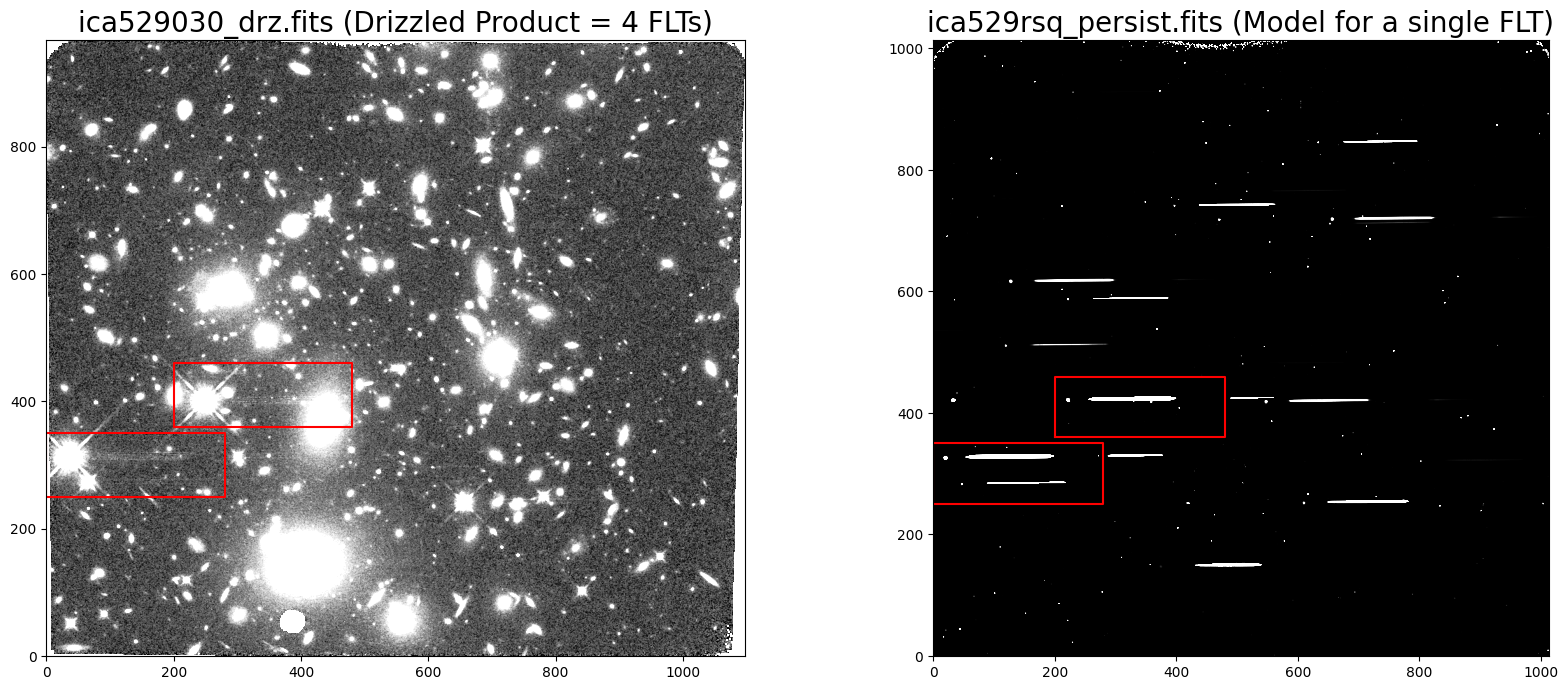

In [5]:
drz = fits.getdata('ica529030_drz.fits', ext=1)
per1 = fits.getdata('13459.Visit29/ica529rsq_persist.fits', ext=1)

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(drz, vmin=0.85, vmax=1.4, cmap='Greys_r', origin='lower')
ax2.imshow(per1, vmin=0.0, vmax=0.005, cmap='Greys_r', origin='lower')

ax1.set_title('ica529030_drz.fits (Drizzled Product = 4 FLTs)', fontsize=20)
ax2.set_title('ica529rsq_persist.fits (Model for a single FLT)', fontsize=20)

ax1.plot([0, 280, 280, 0, 0], [250, 250, 350, 350, 250], c='red')
ax2.plot([0, 280, 280, 0, 0], [250, 250, 350, 350, 250], c='red')
ax1.plot([200, 480, 480, 200, 200], [360, 360, 460, 460, 360], c='red')
ax2.plot([200, 480, 480, 200, 200], [360, 360, 460, 460, 360], c='red')

### 3.2 Use the persistence model to add DQ flags  <a id="flag"></a>

For any pixels in the model with a signal greater than 0.005 e-/sec, we add a flag of 16384 to the current DQ array values in each FLT frame. This threshold is flexible and should be determined empirically by the user based on the science objective and the fraction of pixels impacted. Note that the IR dark rate is 0.049 e-/s, so a threshold of 0.05 e-/s or 0.01 e-/s may be a more reasonable starting value in order to avoid flagging more pixels than can be filled in with the associated dithered FLT frames. 

In [6]:
flt1_dq = fits.open('ica529rmq_flt.fits', mode='update')
per1 = fits.getdata('13459.Visit29/ica529rmq_persist.fits', ext=1)

flt2_dq = fits.open('ica529rsq_flt.fits', mode='update')
per2 = fits.getdata('13459.Visit29/ica529rsq_persist.fits', ext=1)

flt3_dq = fits.open('ica529s0q_flt.fits', mode='update')
per3 = fits.getdata('13459.Visit29/ica529s0q_persist.fits', ext=1)

flt4_dq = fits.open('ica529s6q_flt.fits', mode='update')
per4 = fits.getdata('13459.Visit29/ica529s6q_persist.fits', ext=1)

flt1_dq[3].data[per1 > 0.005] += 16384
flt2_dq[3].data[per2 > 0.005] += 16384
flt3_dq[3].data[per3 > 0.005] += 16384
flt4_dq[3].data[per4 > 0.005] += 16384

flt1_dq.close()
flt2_dq.close()
flt3_dq.close()
flt4_dq.close()

### 3.3 Redrizzle the FLT data and apply the new DQ flags  <a id="drizzle"></a>

Now, we recombine the FLT data with AstroDrizzle using the updated DQ arrays and compare with the pipeline DRZ data products. The following cell uses the default parameter values recommended for the IR detector, where `final_bits` tells AstroDrizzle which DQ flags to ignore (e.g. to treat as good data). All other flagged (non-zero) values will be treated as bad pixels and excluded from the combined image. 

In [7]:
astrodrizzle.AstroDrizzle('ica529*flt.fits', output='ica529030_pcorr',
                          preserve=False, build=True, clean=True, 
                          skymethod='match', sky_bits='16',
                          driz_sep_bits='512,16', combine_type='median',
                          driz_cr_snr='5.0 4.0', driz_cr_scale='3.0 2.4', 
                          final_bits='512,16', num_cores=1)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.7.1.1 started at: 19:03:38.063 (04/12/2024)


AstroDrizzle Version 3.7.1.1 started at: 19:03:38.063 (04/12/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version 3.11.10 (main, Sep  9 2024, 03:20:16) [GCC 9.4.0]


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.26.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 7.0.0 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.3 


INFO:drizzlepac.astrodrizzle:photutils Version -> 1.12.0 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  19:03:38.068 (04/12/2024)


==== Processing Step  Initialization  started at  19:03:38.068 (04/12/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: ica529030_pcorr_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.1965445784641368


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.32831753117871104


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.026946752843298186


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ica529rmq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ica529rsq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ica529s0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ica529s6q_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


INFO:astropy.wcs.wcs:CRVAL : 109.39115497663148 37.74674036479102 


CRVAL : 109.39115497663148 37.74674036479102 


INFO:astropy.wcs.wcs:CRPIX : 549.0 484.0 


CRPIX : 549.0 484.0 


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -2.9182452866972983e-05 -2.0433431583836142e-05 


CD1_1 CD1_2  : -2.9182452866972983e-05 -2.0433431583836142e-05 


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -2.0433431583836142e-05 2.9182452866972983e-05 


CD2_1 CD2_2  : -2.0433431583836142e-05 2.9182452866972983e-05 


INFO:astropy.wcs.wcs:NAXIS : 1098  968


NAXIS : 1098  968


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 20 Mb.


*  Estimated memory usage:  up to 20 Mb.


INFO:drizzlepac.processInput:*  Output image size:       1098 X 968 pixels. 


*  Output image size:       1098 X 968 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 12 Mb. 


*  Output image file:       ~ 12 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 19:03:38.682 (04/12/2024)


==== Processing Step Initialization finished at 19:03:38.682 (04/12/2024)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	True


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	ica529*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	1


INFO:drizzlepac.astrodrizzle:	output :	ica529030_pcorr


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	rules_file :	


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  19:03:38.696 (04/12/2024)


==== Processing Step  Static Mask  started at  19:03:38.696 (04/12/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.201995;   rms = 0.224054;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.002127;   rms = 0.192855;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.331799;   rms = 0.229069;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.027154;   rms = 0.193714;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./ica529030_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step Static Mask finished at 19:03:38.769 (04/12/2024)


==== Processing Step Static Mask finished at 19:03:38.769 (04/12/2024)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  19:03:38.771 (04/12/2024)


==== Processing Step  Subtract Sky  started at  19:03:38.771 (04/12/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	16


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2024-12-04 19:03:38.844192


***** skymatch started on 2024-12-04 19:03:38.844192


INFO:stsci.skypac.utils:      Version 1.0.10


      Version 1.0.10


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ica529rmq_flt.fits'


   **  Input image: 'ica529rmq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ica529rmq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ica529rmq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ica529rsq_flt.fits'


   **  Input image: 'ica529rsq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ica529rsq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ica529rsq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ica529s0q_flt.fits'


   **  Input image: 'ica529s0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ica529s0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ica529s0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ica529s6q_flt.fits'


   **  Input image: 'ica529s6q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ica529s6q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ica529s6q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ica529rmq_flt.fits


   *   Image: ica529rmq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ica529rsq_flt.fits


   *   Image: ica529rsq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ica529s0q_flt.fits


   *   Image: ica529s0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ica529s6q_flt.fits


   *   Image: ica529s6q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ica529rmq_flt.fits['SCI',1]' SKY = 11.7164 [brightness units]


   *   Image 'ica529rmq_flt.fits['SCI',1]' SKY = 11.7164 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.192713


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.192713


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ica529rsq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ica529rsq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ica529s0q_flt.fits['SCI',1]' SKY = 19.8751 [brightness units]


   *   Image 'ica529s0q_flt.fits['SCI',1]' SKY = 19.8751 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.326906


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.326906


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ica529s6q_flt.fits['SCI',1]' SKY = 1.80693 [brightness units]


   *   Image 'ica529s6q_flt.fits['SCI',1]' SKY = 1.80693 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0297206


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0297206


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2024-12-04 19:03:42.170185


***** skymatch ended on 2024-12-04 19:03:42.170185


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:03.325993


TOTAL RUN TIME: 0:00:03.325993


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 19:03:42.238 (04/12/2024)


==== Processing Step Subtract Sky finished at 19:03:42.238 (04/12/2024)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  19:03:42.240 (04/12/2024)


==== Processing Step  Separate Drizzle  started at  19:03:42.240 (04/12/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': True, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 528, 'compress': False, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	528


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	compress :	False


INFO:drizzlepac.adrizzle:	crbit :	None


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	turbo


INFO:drizzlepac.adrizzle:	num_cores :	1


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	electrons


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	None


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel turbo


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


INFO:astropy.wcs.wcs:CRVAL : 109.39115497663148 37.74674036479102 


CRVAL : 109.39115497663148 37.74674036479102 


INFO:astropy.wcs.wcs:CRPIX : 549.0 484.0 


CRPIX : 549.0 484.0 


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -2.9182452866972983e-05 -2.0433431583836142e-05 


CD1_1 CD1_2  : -2.9182452866972983e-05 -2.0433431583836142e-05 


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -2.0433431583836142e-05 2.9182452866972983e-05 


CD2_1 CD2_2  : -2.0433431583836142e-05 2.9182452866972983e-05 


INFO:astropy.wcs.wcs:NAXIS : 1098  968


NAXIS : 1098  968


INFO:drizzlepac.adrizzle:Executing serially


INFO:drizzlepac.adrizzle:-Drizzle input: ica529rmq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.192713 to ica529rmq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.outputimage:-Generating simple FITS output: ica529rmq_single_sci.fits


-Generating simple FITS output: ica529rmq_single_sci.fits


  warnings.warn(



INFO:drizzlepac.outputimage:Writing out image to disk: ica529rmq_single_sci.fits


Writing out image to disk: ica529rmq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529rmq_single_wht.fits


Writing out image to disk: ica529rmq_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: ica529rsq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ica529rsq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.outputimage:-Generating simple FITS output: ica529rsq_single_sci.fits


-Generating simple FITS output: ica529rsq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529rsq_single_sci.fits


Writing out image to disk: ica529rsq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529rsq_single_wht.fits


Writing out image to disk: ica529rsq_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: ica529s0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.326906 to ica529s0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.outputimage:-Generating simple FITS output: ica529s0q_single_sci.fits


-Generating simple FITS output: ica529s0q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529s0q_single_sci.fits


Writing out image to disk: ica529s0q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529s0q_single_wht.fits


Writing out image to disk: ica529s0q_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: ica529s6q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.029721 to ica529s6q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.outputimage:-Generating simple FITS output: ica529s6q_single_sci.fits


-Generating simple FITS output: ica529s6q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529s6q_single_sci.fits


Writing out image to disk: ica529s6q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529s6q_single_wht.fits


Writing out image to disk: ica529s6q_single_wht.fits


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 19:03:43.529 (04/12/2024)


==== Processing Step Separate Drizzle finished at 19:03:43.529 (04/12/2024)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  19:03:43.530 (04/12/2024)


==== Processing Step  Create Median  started at  19:03:43.530 (04/12/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:


INFO:drizzlepac.createMedian:	combine_bufsize :	None


INFO:drizzlepac.createMedian:	combine_grow :	1


INFO:drizzlepac.createMedian:	combine_hthresh :	None


INFO:drizzlepac.createMedian:	combine_lthresh :	None


INFO:drizzlepac.createMedian:	combine_maskpt :	0.3


INFO:drizzlepac.createMedian:	combine_nhigh :	0


INFO:drizzlepac.createMedian:	combine_nlow :	0


INFO:drizzlepac.createMedian:	combine_nsigma :	4 3


INFO:drizzlepac.createMedian:	combine_type :	median


INFO:drizzlepac.createMedian:	compress :	False


INFO:drizzlepac.createMedian:	median :	True


INFO:drizzlepac.createMedian:	median_newmasks :	True


INFO:drizzlepac.createMedian:	proc_unit :	native


INFO:drizzlepac.createMedian:reference sky value for image 'ica529rmq_flt.fits' is 29.472217944874348


reference sky value for image 'ica529rmq_flt.fits' is 29.472217944874348


INFO:drizzlepac.createMedian:reference sky value for image 'ica529rsq_flt.fits' is 0.0


reference sky value for image 'ica529rsq_flt.fits' is 0.0


INFO:drizzlepac.createMedian:reference sky value for image 'ica529s0q_flt.fits' is 49.994920358765874


reference sky value for image 'ica529s0q_flt.fits' is 49.994920358765874


INFO:drizzlepac.createMedian:reference sky value for image 'ica529s6q_flt.fits' is 6.031314646382094


reference sky value for image 'ica529s6q_flt.fits' is 6.031314646382094


INFO:drizzlepac.createMedian:Saving output median image to: 'ica529030_pcorr_med.fits'


Saving output median image to: 'ica529030_pcorr_med.fits'


INFO:drizzlepac.util:==== Processing Step Create Median finished at 19:03:43.718 (04/12/2024)


==== Processing Step Create Median finished at 19:03:43.718 (04/12/2024)


INFO:drizzlepac.util:==== Processing Step  Blot  started at  19:03:43.720 (04/12/2024)


==== Processing Step  Blot  started at  19:03:43.720 (04/12/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:


INFO:drizzlepac.ablot:	blot_addsky :	True


INFO:drizzlepac.ablot:	blot_interp :	poly5


INFO:drizzlepac.ablot:	blot_sinscl :	1.0


INFO:drizzlepac.ablot:	blot_skyval :	0.0


INFO:drizzlepac.ablot:	coeffs :	True


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ica529rmq_flt.fits[sci,1]


    Blot: creating blotted image:  ica529rmq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.192713 to blotted image ica529rmq_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ica529rmq_sci1_blt.fits


-Generating simple FITS output: ica529rmq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529rmq_sci1_blt.fits


Writing out image to disk: ica529rmq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ica529rsq_flt.fits[sci,1]


    Blot: creating blotted image:  ica529rsq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image ica529rsq_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ica529rsq_sci1_blt.fits


-Generating simple FITS output: ica529rsq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529rsq_sci1_blt.fits


Writing out image to disk: ica529rsq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ica529s0q_flt.fits[sci,1]


    Blot: creating blotted image:  ica529s0q_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.326906 to blotted image ica529s0q_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ica529s0q_sci1_blt.fits


-Generating simple FITS output: ica529s0q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529s0q_sci1_blt.fits


Writing out image to disk: ica529s0q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ica529s6q_flt.fits[sci,1]


    Blot: creating blotted image:  ica529s6q_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.029721 to blotted image ica529s6q_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ica529s6q_sci1_blt.fits


-Generating simple FITS output: ica529s6q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ica529s6q_sci1_blt.fits


Writing out image to disk: ica529s6q_sci1_blt.fits


INFO:drizzlepac.util:==== Processing Step Blot finished at 19:03:44.551 (04/12/2024)


==== Processing Step Blot finished at 19:03:44.551 (04/12/2024)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  19:03:44.552 (04/12/2024)


==== Processing Step  Driz_CR  started at  19:03:44.552 (04/12/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:


INFO:drizzlepac.drizCR:	crbit :	4096


INFO:drizzlepac.drizCR:	driz_cr :	True


INFO:drizzlepac.drizCR:	driz_cr_corr :	False


INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0


INFO:drizzlepac.drizCR:	driz_cr_grow :	1


INFO:drizzlepac.drizCR:	driz_cr_scale :	3.0 2.4


INFO:drizzlepac.drizCR:	driz_cr_snr :	5.0 4.0


INFO:drizzlepac.drizCR:	inmemory :	False


INFO:drizzlepac.drizCR:Executing serially


INFO:drizzlepac.drizCR:Creating output: ica529rmq_sci1_crmask.fits


Creating output: ica529rmq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ica529rsq_sci1_crmask.fits


Creating output: ica529rsq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ica529s0q_sci1_crmask.fits


Creating output: ica529s0q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ica529s6q_sci1_crmask.fits


Creating output: ica529s6q_sci1_crmask.fits


INFO:drizzlepac.util:==== Processing Step Driz_CR finished at 19:03:45.018 (04/12/2024)


==== Processing Step Driz_CR finished at 19:03:45.018 (04/12/2024)


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  19:03:45.019 (04/12/2024)


==== Processing Step  Final Drizzle  started at  19:03:45.019 (04/12/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': True, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 528, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	528


INFO:drizzlepac.adrizzle:	build :	True


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


INFO:astropy.wcs.wcs:CRVAL : 109.39115497663148 37.74674036479102 


CRVAL : 109.39115497663148 37.74674036479102 


INFO:astropy.wcs.wcs:CRPIX : 549.0 484.0 


CRPIX : 549.0 484.0 


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -2.9182452866972983e-05 -2.0433431583836142e-05 


CD1_1 CD1_2  : -2.9182452866972983e-05 -2.0433431583836142e-05 


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -2.0433431583836142e-05 2.9182452866972983e-05 


CD2_1 CD2_2  : -2.0433431583836142e-05 2.9182452866972983e-05 


INFO:astropy.wcs.wcs:NAXIS : 1098  968


NAXIS : 1098  968


INFO:drizzlepac.adrizzle:-Drizzle input: ica529rmq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.192713 to ica529rmq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ica529rsq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ica529rsq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ica529s0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.326906 to ica529s0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ica529s6q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.029721 to ica529s6q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating multi-extension output file:  ica529030_pcorr_drz.fits


-Generating multi-extension output file:  ica529030_pcorr_drz.fits


INFO:stwcs.wcsutil.altwcs:Deleted all instances of WCS with key A in extensions [1]


Deleted all instances of WCS with key A in extensions [1]


INFO:stwcs.wcsutil.altwcs:Deleted all instances of WCS with key B in extensions [1]


Deleted all instances of WCS with key B in extensions [1]


INFO:drizzlepac.outputimage:Writing out to disk: ica529030_pcorr_drz.fits


Writing out to disk: ica529030_pcorr_drz.fits


  warnings.warn(



INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 19:03:46.716 (04/12/2024)


==== Processing Step Final Drizzle finished at 19:03:46.716 (04/12/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.7.1.1 is finished processing at 19:03:46.719 (04/12/2024).


AstroDrizzle Version 3.7.1.1 is finished processing at 19:03:46.719 (04/12/2024).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          0.6137 sec.


         Initialization          0.6137 sec.


INFO:drizzlepac.util:            Static Mask          0.0738 sec.


            Static Mask          0.0738 sec.


INFO:drizzlepac.util:           Subtract Sky          3.4662 sec.


           Subtract Sky          3.4662 sec.


INFO:drizzlepac.util:       Separate Drizzle          1.2892 sec.


       Separate Drizzle          1.2892 sec.


INFO:drizzlepac.util:          Create Median          0.1880 sec.


          Create Median          0.1880 sec.


INFO:drizzlepac.util:                   Blot          0.8308 sec.


                   Blot          0.8308 sec.


INFO:drizzlepac.util:                Driz_CR          0.4653 sec.


                Driz_CR          0.4653 sec.


INFO:drizzlepac.util:          Final Drizzle          1.6971 sec.


          Final Drizzle          1.6971 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          8.6242 sec.


                  Total          8.6242 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for ica529rmq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ica529rsq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ica529s0q_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ica529s6q_flt.fits


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### 3.4 Compare the original and corrected DRZ files  <a id="compare"></a>

Here, we display the drizzled image from the pipeline and the reprocessed drizzled image with persistence masked. 

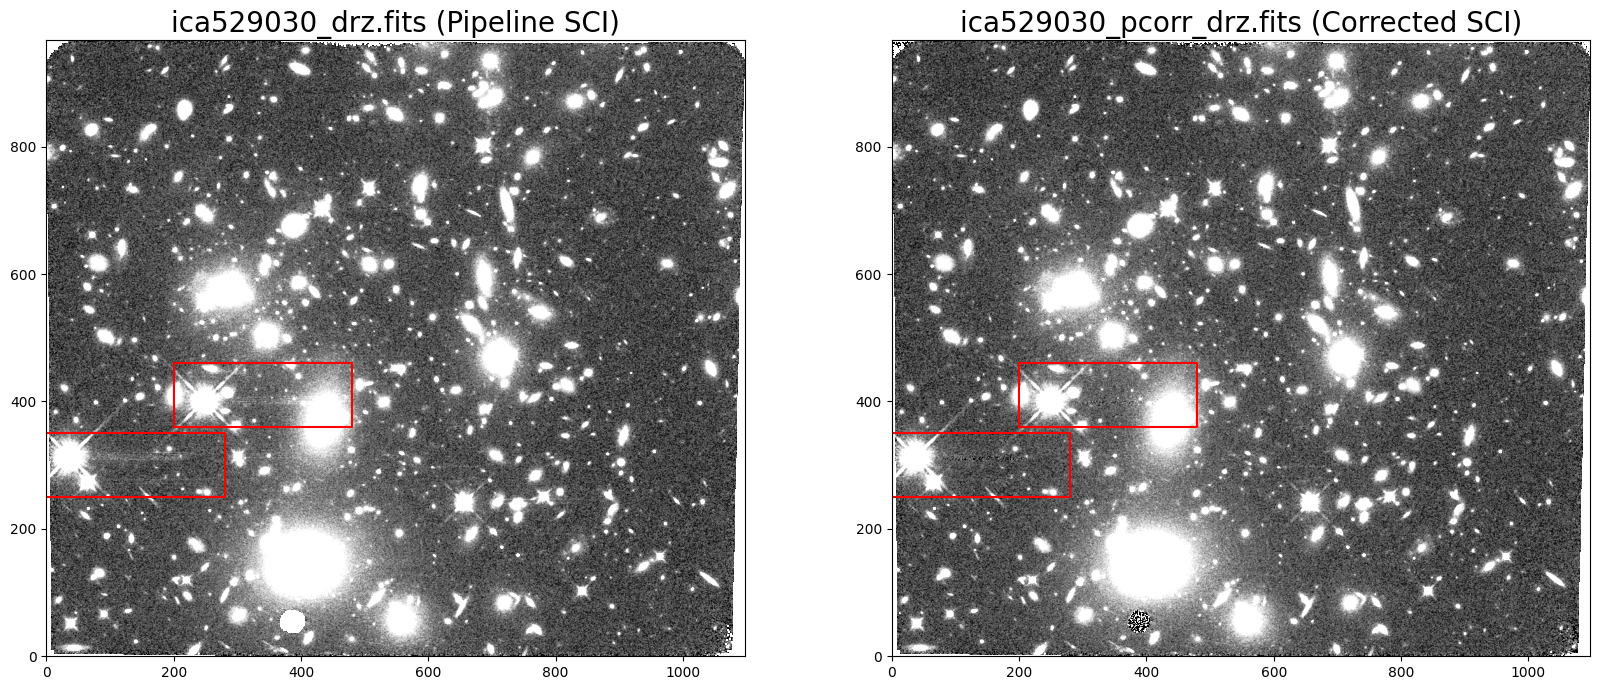

In [8]:
drz = fits.getdata('ica529030_drz.fits', ext=1)
drz_corr = fits.getdata('ica529030_pcorr_drz.fits', ext=1)

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(drz, vmin=0.85, vmax=1.4, cmap='Greys_r', origin='lower')
ax2.imshow(drz_corr, vmin=0.85, vmax=1.4, cmap='Greys_r', origin='lower')

ax1.set_title('ica529030_drz.fits (Pipeline SCI)', fontsize=20)
ax2.set_title('ica529030_pcorr_drz.fits (Corrected SCI)', fontsize=20)

ax1.plot([0, 280, 280, 0, 0], [250, 250, 350, 350, 250], c='red')
ax2.plot([0, 280, 280, 0, 0], [250, 250, 350, 350, 250], c='red')
ax1.plot([200, 480, 480, 200, 200], [360, 360, 460, 460, 360], c='red')
ax2.plot([200, 480, 480, 200, 200], [360, 360, 460, 460, 360], c='red')

### 3.5 Compare the original and corrected WHT files  <a id="weight"></a>

When `final_wht_type='EXP'`, the drizzled weight (WHT) images provide an effective exposure time map of the combined array. 

In the plots below, we can see that the pipeline products have lower weight in the region impacted by the grism, but that only a single frame was flagged and rejected by the cosmic ray algorithm. The grey horizontal bars have a weight ~500 seconds compared to the total exposure ~700 seconds.

In the redrizzled 'corrected' WHT image, only a single exposure contributed to the darkest horizontal bars which have a value of ~200 seconds. The adjacent grey bars have a weight ~500 seconds and the rest of the WHT image is ~700 seconds. Users will need to experiment with the persistence masking thresholds and consider the size of the dithers in their individual datasets to determine the best masking strategy.

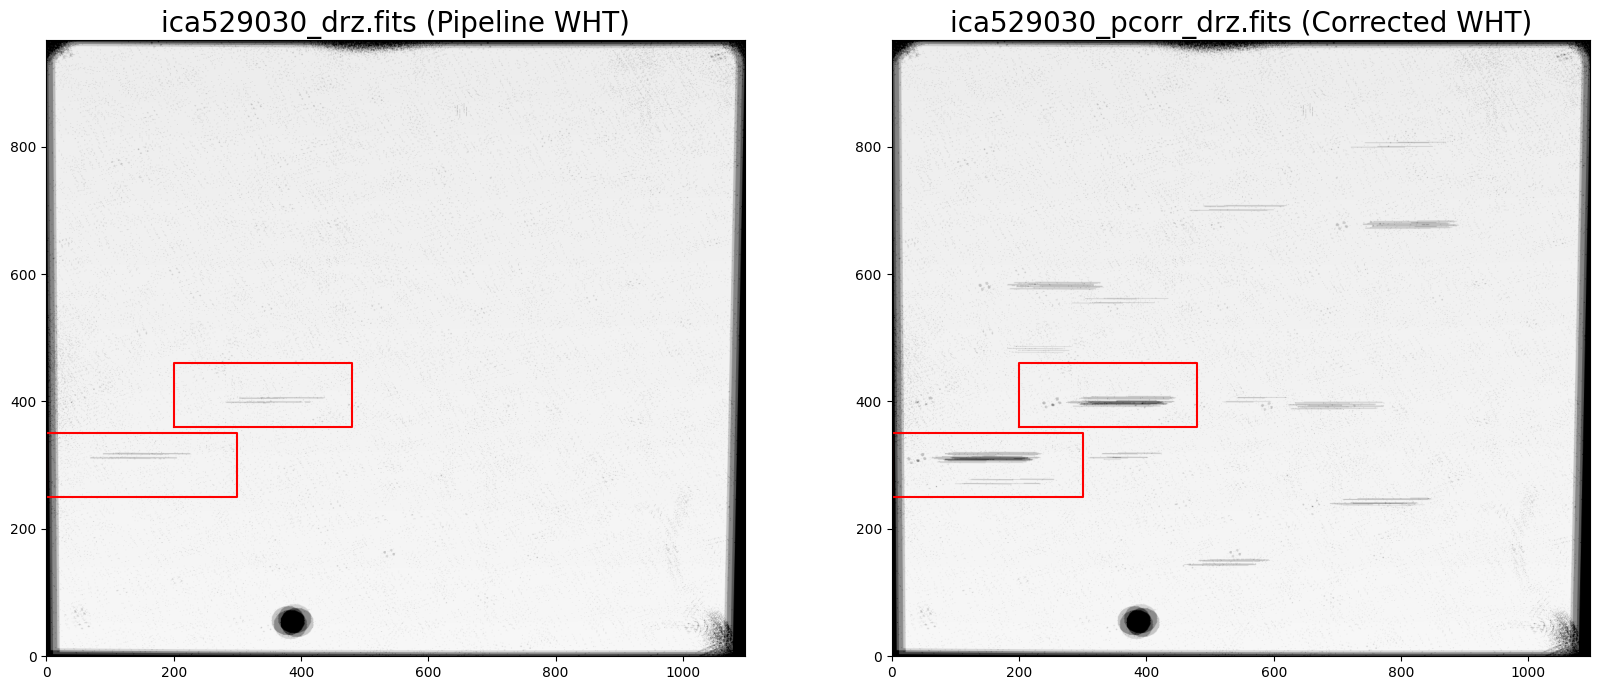

In [9]:
wht = fits.getdata('ica529030_drz.fits', ext=2)
wht_corr = fits.getdata('ica529030_pcorr_drz.fits', ext=2)

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(wht, vmin=0, vmax=800, cmap='Greys_r', origin='lower')
ax2.imshow(wht_corr, vmin=0, vmax=800, cmap='Greys_r', origin='lower')

ax1.set_title('ica529030_drz.fits (Pipeline WHT)', fontsize=20)
ax2.set_title('ica529030_pcorr_drz.fits (Corrected WHT)', fontsize=20)

ax1.plot([0, 300, 300, 0, 0], [250, 250, 350, 350, 250], c='red')
ax2.plot([0, 300, 300, 0, 0], [250, 250, 350, 350, 250], c='red')
ax1.plot([200, 480, 480, 200, 200], [360, 360, 460, 460, 360], c='red')
ax2.plot([200, 480, 480, 200, 200], [360, 360, 460, 460, 360], c='red')

## 4. Conclusions <a id="conclusions"></a>

Thank you for walking through this notebook. Now with WFC3 data, you should be familiar with:

- Examining the persistence models for a given dataset.
- Defining a threshold to use for masking pixels in the DQ array of FLT science frames.
- Reprocessing dithered frames with the new DQ flags to produce an improved combined DRZ image.

**Congratulations, you have completed the notebook.**

## Additional Resources <a id="add"></a>

Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
    - see Sections 5.7.9 and 7.9.4 for a discussion of IR persistence
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see Section 8.1 for a discussion of IR persistence
    - see Section 8.2 for evaluating the amount of persistence in science images
    - see Section 8.3 for a discussion methods for mitigating persistence
- [DrizzlePac Handbook](https://hst-docs.stsci.edu/drizzpac)


## About this Notebook <a id="about"></a>

**Author:** Jennifer Mack, WFC3 Instrument Team

**Created On:** 2021-09-28

**Updated On:** 2023-11-06

**Source:** The notebook is sourced from [hst_notebooks/notebooks/WFC3/persistence](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/persistence).

## Citations <a id="cite"></a>
If you use `astropy`, `astroquery`, `ccdproc`, or `drizzlepac` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/license.html)
* [Citing `ccdproc`](https://ccdproc.readthedocs.io/en/latest/license.html)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)
***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 